In [1]:
from pytesseract import pytesseract
from PIL import Image

In [2]:
img = 'tests/images/schematic.jpg'
imge = Image.open(img)
data=pytesseract.image_to_boxes(imge)

print(data)

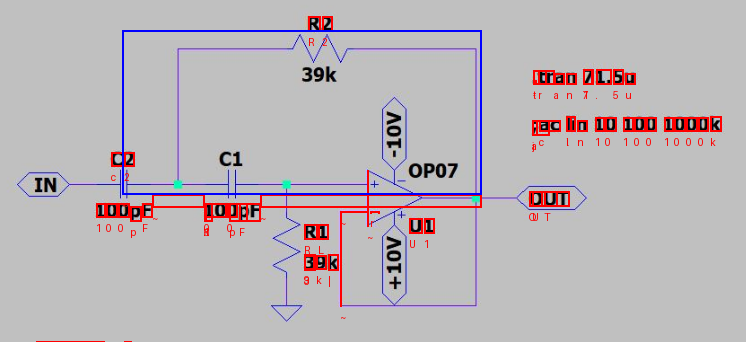

In [3]:
from PIL import Image, ImageDraw
import pytesseract
from IPython.display import display
import numpy as np

img_path = 'tests/images/schematic.png'
image = Image.open(img_path)

# Get image dimensions
width, height = image.size

# Array to store box sizes
box_areas = []

# Get bounding box data
data = pytesseract.image_to_boxes(image)

# Create a drawing object
draw = ImageDraw.Draw(image)

# Iterate over each box in the data and draw a rectangle
for box in data.splitlines():
    b = box.split()
    # Extract coordinates
    x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])

    # Calculate box size (width * height)
    box_area = (w - x) * (h - y)
    box_areas.append(box_area)
    
    # Adjust y-coordinate to correct for the coordinate system difference
    h_flip = height - y
    y_flip = height - h
    
    # Draw rectangle on the image
    draw.rectangle([x, y_flip, w, h_flip], outline='red', width=2)
    draw.text((x, h_flip + 5), box[0], fill='red')

std_dev = np.std(box_areas)

# Define the confidence interval (adjust as needed)
confidence_interval = 1.96  # for a 95% confidence interval

# Determine the upper and lower bounds of the confidence interval
lower_bound = np.mean(box_areas) - confidence_interval * std_dev
upper_bound = np.mean(box_areas) + confidence_interval * std_dev

# Color boxes above the median differently
for box, box_size in zip(data.splitlines(), box_areas):
    b = box.split()
    x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
    h_flip = height - y
    y_flip = height - h
    
    if box_size < lower_bound or box_size > upper_bound:
        draw.rectangle([x, y_flip, w, h_flip], outline='blue', width=2)

# Display the image with bounding boxes in Jupyter Notebook
display(image)




In [15]:
from scipy.stats import gaussian_kde

def get_scaling_from_OCR(img_path: str, threshold: int=5, letter_to_part_ratio: float=1/3) -> float:
    """
    BRIEF
    -----
    Get the estimated size of a component in relation to the image size in percent.
    This approach uses `pytesseract` to get the bounding boxes of the OCR-scan
    performed on the image. After that, the width of these boxes is used to form
    an interpolated gaussian distribution of widths, from which the peak and 
    values within a threshold are taken and calculated into a mean peak value. 
    This is then multiplied by the assumed relation of font-size and component-size
    and divided by the image width and returned as percent.

    PARAMS
    ------
    `img_path`: str
        Path to image.
    `threshold`: int
        Defines which values `threshold` lower than the peak are taken into the 
        mean-operation.
    `letter_to_part_ratio`: float
        Assumed size of letter in relation to component size.
    
    RETURNS
    -------
    `float`:
        Ratio of component size to image size.
    """
    image = Image.open(img_path)
    width, height = image.size
    box_widths = []
    data = pytesseract.image_to_boxes(image)
    draw = ImageDraw.Draw(image)
    for box in data.splitlines():
        b = box.split()
        x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
        box_widths.append(w - x) # log width of letters, ignore height for now
    
    kde = gaussian_kde(box_widths)
    x_vals = np.linspace(min(box_widths), max(box_widths), 1000)
    y_vals = kde(x_vals)
    peak_index = np.argmax(y_vals)
    peak_value = x_vals[peak_index]
    selected_values = [value for value in box_widths if abs(value - peak_value) <= threshold]
    result_mean = np.mean(selected_values)
    return (1/letter_to_part_ratio) * result_mean / width

get_scaling_from_OCR(img_path)

0.04255252821248207